# 第一次作业：共享单车预测器

姓名：颜林林

学号：025

## 要求

实现一个三分类网络，对自行车预测数据进行高、中、低这三个类别的划分。

## 实现过程

### 1. 准备

In [1]:
## 初始化

# 函数库装载
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable

# 直接插入绘制图表
%matplotlib inline

In [2]:
## 数据读取

# 原始数据读取
data_path = 'bike-sharing-dataset/hour.csv'
rides = pd.read_csv(data_path)

In [3]:
## 数据预处理

data = rides

# 转换类型变量到独热编码
dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday'] # 所有类型编码变量名
for each in dummy_fields:
    dummies = pd.get_dummies(rides[each], prefix=each, drop_first=False)
    data = pd.concat([data, dummies], axis=1)

# 删除不需要的变量
fields_to_drop = ['instant', 'dteday', 'season', 'weathersit', 'weekday', 'atemp', 'mnth', 'workingday', 'hr'] # 要删除的变量名
data = data.drop(fields_to_drop, axis = 1)

# 数据标准化
quant_features = ['cnt', 'temp', 'hum', 'windspeed']
scaled_features = {}
for each in quant_features:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean)/std

# 输出结果分类（单车数：低、中、高，按三分位划分）
low, high = np.quantile(data['cnt'], (1/3, 2/3))
data['cnt_low'] = data['cnt'] <= low
data['cnt_mid'] = np.logical_and(data['cnt'] > low, data['cnt'] <= high)
data['cnt_high'] = data['cnt'] > high

In [4]:
## 数据集划分

train_data = data[:-21*24]
test_data = data[-21*24:]

target_fields = ['cnt', 'casual', 'registered', 'cnt_low', 'cnt_mid', 'cnt_high']

train_features, train_targets = train_data.drop(target_fields, axis=1), train_data[target_fields]
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]

In [15]:
## 构建神经网络

input_size = train_features.shape[1]
hidden_size = 10
output_size = 3 # 输出三分类
neu = torch.nn.Sequential(
    torch.nn.Linear(input_size, hidden_size),
    torch.nn.Sigmoid(),
    torch.nn.Linear(hidden_size, output_size),
    torch.nn.Sigmoid(),
    torch.nn.S
)
cost = torch.nn.NLLLoss()
#cost = torch.nn.MSELoss()
optimizer = torch.optim.SGD(neu.parameters(), lr = 0.01)

### 2. 训练

In [16]:
## 训练神经网络

X = train_features.values
Y = train_targets[['cnt_low', 'cnt_mid', 'cnt_high']].values

losses = []

batch_size = 128
for i in range(1000):
    batch_loss = []
    for start in range(0, len(X), batch_size):
        end = start + batch_size if start + batch_size < len(X) else len(X)
        xx = torch.tensor(X[start:end], dtype = torch.float)
        yy = torch.tensor(Y[start:end], dtype = torch.float)
        predict = neu(xx)
        loss = cost(predict, yy)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        batch_loss.append(loss.data.numpy())
    if i % 100==0:
        losses.append(np.mean(batch_loss))
        print(i, np.mean(batch_loss))

RuntimeError: Expected object of scalar type Long but got scalar type Float for argument #2 'target'

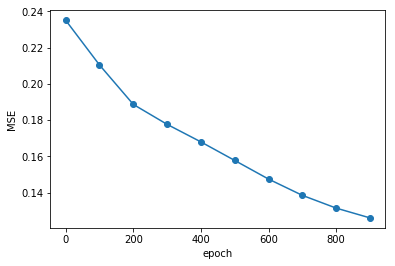

In [7]:
plt.plot(np.arange(len(losses))*100, losses, 'o-')
plt.xlabel("epoch")
plt.ylabel("MSE")
plt.show()

### 3. 预测

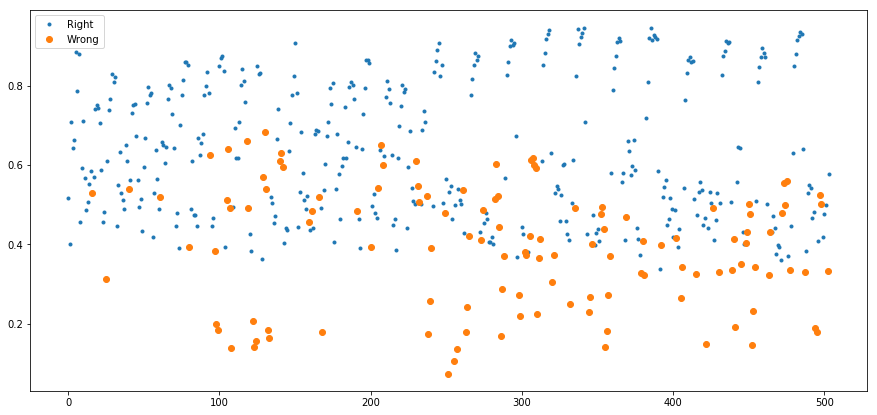

In [8]:
targets = test_targets[['cnt_low','cnt_mid','cnt_high']].values

x = torch.tensor(test_features.values, dtype = torch.float)
y = torch.tensor(targets, dtype = torch.float)

predict = neu(x)
prob = predict.data.numpy()

exp_level = np.argmax(targets, 1)
pred_level = np.argmax(prob, 1)
rights = (exp_level == pred_level)
wrongs = (exp_level != pred_level)
right_index = np.arange(len(rights))[rights]
rightness = prob[right_index, pred_level[right_index]]
wrong_index = np.arange(len(wrongs))[wrongs]
wrongness = prob[wrong_index, 1 - pred_level[wrong_index]]

fig, ax = plt.subplots(figsize = (15, 7))
ax.plot(right_index, rightness, ".", label = "Right")
ax.plot(wrong_index, wrongness, "o", label = "Wrong")
ax.legend()
#mean, std = scaled_features['cnt']
#ax.plot(predict * std + mean, label = "Prediction")
#ax.plot(targets * std + mean, label = "Data")
#ax.legend()
#ax.set_xlabel("Date-time")
#ax.set_ylabel("Counts")

In [9]:
prob

array([[0.10542694, 0.5166318 , 0.388859  ],
       [0.2941628 , 0.39967433, 0.21003988],
       [0.7075487 , 0.23862095, 0.07181258],
       ...,
       [0.27357575, 0.50006217, 0.16054513],
       [0.33240208, 0.5104772 , 0.11309717],
       [0.57733595, 0.4252176 , 0.05764525]], dtype=float32)

In [14]:
prob[2,:].sum()

1.0179822